In [1]:
# this file takes in all files and produce the appropriate s2d analysis
from pathlib import Path
from datasets import load_dataset
from evaluate import load
import pandas as pd
import numpy as np
from pathlib import Path
from functional import seq
from funcutils import underscore as _
from funcutils import get
from IPython.display import display, display_html, HTML
from editdistance import distance as edit_distance

import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn-v0_8-whitegrid')
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"]}
plt.rcParams.update(params)

In [3]:
dspl_html = lambda x: display_html(x, raw=True)
rouge = load('rouge')

In [4]:
root_path = Path("/home/vente/repos/nlgs-research")


INPUT_TO_ANALYSE = ""

# TODO: get this file form argv so driver code can run all analyses in a loop
# or just analayse the outputs of the best model...?
pkl = max( (root_path / "pipeline/predictions").glob("*s2d*"))
pkl.name

's2d-t5-small-5.pkl'

In [5]:
OUTPUT_PATH = Path("/home/vente/repos/nlgs-research/pipeline/scores") / pkl.name.removesuffix(".pkl")
OUTPUT_PATH.mkdir(exist_ok=True)
OUTPUT_PATH

PosixPath('/home/vente/repos/nlgs-research/pipeline/scores/s2d-t5-small-5')

In [6]:
# corpus = pd.read_pickle(root_path / "pipeline/normalized_data/webnlg_clean.pkl")
test_predictions = pd.read_pickle(pkl)
# test_corpus = corpus[corpus['subset']=='test'].copy()
# test_corpus 

In [7]:
compute_rouge = lambda x,y: rouge.compute(references=[x], predictions=[x], use_stemmer=False, use_aggregator=False, rouge_types=['rouge2'])

 How do we formulate F-measure for this task? Usually there is a fixed number
 of classes, and one label per class. But this class is fundimentally about
 extracting many labels from a single sequence.
 Approach: treat one data sample as multiple classification events, compute the
 f-measure across each label in an needs to be order-insensitive by comparing
 the sets themselves

 ```
 TP <- PRED `intersect` GT |> length
 FP <- GT - PRED |> length
 FN <- PRED - GT |> length
 F1 <- harmonic_mean(prec, recl)
 prec <- TP / (TP + FP)
 recl <- TP / (TP + FN)
 ```

In [8]:
# define set notion of precision when multiple labels are assigned
# to a single instance, with epsilon preventing div by zero
def compute_f_measure(pred: set[str], gt: set[str], epsilon=1e-99):
    tp = len(pred.intersection(gt)) # pred true and actually true
    fp = len(gt - pred)             # in pred but not in gt
    fn = len(pred - gt)             # not in pred but actualy true

    prec = tp / (tp + fp + epsilon) 
    recl = tp / (tp + fn + epsilon) 
    f1 = (2 * prec * recl) / (prec + recl + epsilon)
    return f1

 ## Unit Tests

In [9]:
assert compute_f_measure(set("a"), set('a')) == 1
assert compute_f_measure(set("ab"), set('a')) == 2/3
assert compute_f_measure(set() , set('a')) == 0

In [10]:
# don't penalize for quotes or spaces
norm_split_set = lambda x: x.str.upper().str.replace("'", '').str.replace(' ','').map(_.split(";")).map(set)
y_pred = norm_split_set(test_predictions['decoded'])
y_pred

38668    {ABILENEREGIONALAIRPORT|CITYSERVED|ABILENE,TEXAS}
38669    {ABILENEREGIONALAIRPORT|CITYSERVED|ABILENE,TEXAS}
38670    {ADOLFOSUAREZMADRID-BARAJASAIRPORT|LOCATION|MA...
38671    {ADOLFOSUAREZMADRID-BARAJASAIRPORT|LOCATION|MA...
38672    {ADOLFOSUAREZMADRID-BARAJASAIRPORT|LOCATION|MA...
                               ...                        
42887    {SCHOOLOFBUSINESSANDSOCIALSCIENCESATTHEAARHUSU...
42888    {SCHOOLOFBUSINESSANDSOCIALSCIENCESATTHEAARHUSU...
42889    {SCHOOLOFBUSINESSANDSOCIALSCIENCESATTHEAARHUSU...
42890    {SCHOOLOFBUSINESSANDSOCIALSCIENCESATTHEAARHUSU...
42891    {SCHOOLOFBUSINESSANDSOCIALSCIENCESATTHEAARHUSU...
Name: decoded, Length: 4224, dtype: object

In [11]:
y_true = norm_split_set(test_predictions['sd'])
y_true

38668    {ABILENEREGIONALAIRPORT|CITYSERVED|ABILENE,TEXAS}
38669    {ABILENEREGIONALAIRPORT|CITYSERVED|ABILENE,TEXAS}
38670    {ADOLFOSUAREZMADRID-BARAJASAIRPORT|LOCATION|MA...
38671    {ADOLFOSUAREZMADRID-BARAJASAIRPORT|LOCATION|MA...
38672    {ADOLFOSUAREZMADRID-BARAJASAIRPORT|LOCATION|MA...
                               ...                        
42887    {SCHOOLOFBUSINESSANDSOCIALSCIENCESATTHEAARHUSU...
42888    {SCHOOLOFBUSINESSANDSOCIALSCIENCESATTHEAARHUSU...
42889    {SCHOOLOFBUSINESSANDSOCIALSCIENCESATTHEAARHUSU...
42890    {SCHOOLOFBUSINESSANDSOCIALSCIENCESATTHEAARHUSU...
42891    {SCHOOLOFBUSINESSANDSOCIALSCIENCESATTHEAARHUSU...
Name: sd, Length: 4224, dtype: object

In [12]:
f1_scores = seq(y_pred).zip(y_true).starmap(compute_f_measure).to_list()
f1_scores

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

In [13]:
def compute_closest_edit_dists(y_pred, y_true):
    # we need an alignment of the labels by edit distance
    return (
      seq(y_pred)
        .cartesian(y_true)
        .starmap(edit_distance) 
        .sorted()
        # full penalty for missed guesses or too many guesses
        # .take(seq(y_true, y_pred).map(len).max())
        .to_list()
    )

edit_distances = (
  seq(y_pred)
    .zip(y_true)
    .starmap(compute_closest_edit_dists)
    .map(np.mean)
    .to_list()
)
edit_distances 

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 20.0,
 0.0,
 6.0,
 0.0,
 0.0,
 7.0,
 0.0,
 6.5,
 0.0,
 2.0,
 7.0,
 0.0,
 0.0,
 0.0,
 2.0,
 3.0,
 3.0,
 0.0,
 2.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 2.0,
 0.0,
 0.0,
 2.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 7.0,
 10.0,
 10.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 7.0,
 7.0,
 0.0,
 25.5,
 21.0,
 0.0,
 0.0,
 20.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 7.0,
 16.0,
 8.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 27.666666666666668,
 21.5,
 17.5,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 6.0,
 0.0,
 0.0,
 0.0,
 0.0,
 33.5,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.

In [14]:
results = test_predictions
results['f1_scores'] = f1_scores
results['med_scores'] = edit_distances # med mean edit distance
results 

,record_idx,seed_number,subset,category,split_index,sd,nl,input_ids,attention_mask,labels,pred_ids,decoded,f1_scores,med_scores
38668,14495,0,test,Airport,0,"Abilene Regional Airport|city served|Abilene, ...","Abilene, Texas is served by the Abilene region...","[891, 23, 14205, 6, 2514, 19, 2098, 57, 8, 891...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[891, 23, 14205, 7676, 5735, 9175, 6726, 2098,...","[0, 891, 23, 14205, 7676, 5735, 9175, 6726, 20...","Abilene Regional Airport|city served|Abilene, ...",1.000000,0.000000
38669,14495,1,test,Airport,0,"Abilene Regional Airport|city served|Abilene, ...",Abilene Regional Airport serves the city of Ab...,"[891, 23, 14205, 7676, 5735, 4657, 8, 690, 13,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[891, 23, 14205, 7676, 5735, 9175, 6726, 2098,...","[0, 891, 23, 14205, 7676, 5735, 9175, 6726, 20...","Abilene Regional Airport|city served|Abilene, ...",1.000000,0.000000
38670,14496,0,test,Airport,1,Adolfo Suarez Madrid-Barajas Airport|location|...,Adolfo Suarez Madrid-Barajas Airport can be fo...,"[1980, 32, 40, 89, 32, 1923, 9, 2638, 12033, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1980, 32, 40, 89, 32, 1923, 9, 2638, 12033, 1...","[0, 1980, 32, 40, 89, 32, 1923, 9, 2638, 12033...",Adolfo Suarez Madrid-Barajas Airport|location|...,1.000000,0.000000
38671,14496,1,test,Airport,1,Adolfo Suarez Madrid-Barajas Airport|location|...,Adolfo Suarez Madrid-Barajas airport is locate...,"[1980, 32, 40, 89, 32, 1923, 9, 2638, 12033, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1980, 32, 40, 89, 32, 1923, 9, 2638, 12033, 1...","[0, 1980, 32, 40, 89, 32, 1923, 9, 2638, 12033...",Adolfo Suarez Madrid-Barajas Airport|location|...,1.000000,0.000000
38672,14496,2,test,Airport,1,Adolfo Suarez Madrid-Barajas Airport|location|...,Adolfo Suarez Madrid-Barajas Airport is locate...,"[1980, 32, 40, 89, 32, 1923, 9, 2638, 12033, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1980, 32, 40, 89, 32, 1923, 9, 2638, 12033, 1...","[0, 1980, 32, 40, 89, 32, 1923, 9, 2638, 12033...",Adolfo Suarez Madrid-Barajas Airport|location|...,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42887,16092,1,test,University,1597,School of Business and Social Sciences at the ...,"Established in 1928, the School of Business an...","[25275, 16, 29004, 6, 8, 1121, 13, 1769, 11, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1121, 13, 1769, 11, 2730, 9226, 44, 8, 71, 29...","[0, 1121, 13, 1769, 11, 2730, 9226, 44, 8, 71,...",School of Business and Social Sciences at the ...,0.769231,29.404762
42888,16093,0,test,University,1598,School of Business and Social Sciences at the ...,Denmark is led by the Monarchy of Demark and t...,"[18001, 19, 2237, 57, 8, 2963, 7064, 63, 13, 3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1121, 13, 1769, 11, 2730, 9226, 44, 8, 71, 29...","[0, 1121, 13, 1769, 11, 2730, 9226, 44, 8, 71,...",School of Business and Social Sciences at the ...,0.666667,41.457143
42889,16093,1,test,University,1598,School of Business and Social Sciences at the ...,The School of Business and Social Sciences at ...,"[37, 1121, 13, 1769, 11, 2730, 9226, 44, 8, 71...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1121, 13, 1769, 11, 2730, 9226, 44, 8, 71, 29...","[0, 1121, 13, 1769, 11, 2730, 9226, 44, 8, 71,...",School of Business and Social Sciences at the ...,0.727273,41.821429
42890,16093,2,test,University,1598,School of Business and Social Sciences at the ...,The School of Business and Social Sciences at ...,"[37, 1121, 13, 1769, 11, 2730, 9226, 44, 8, 71...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1121, 13, 1769, 11, 2730, 9226, 44, 8, 71, 29...","[0, 1121, 13, 1769, 11, 2730, 9226, 44, 8, 71,...",School of Business and Social Sciences at the ...,0.666667,42.200000


In [15]:
# let's define nth finish and "place-number" as 0 for "finishing in first place"
# give find the place-number given a score: ties should have the same place
score_to_nth_finish: dict[float, int]= (
  seq(f1_scores)
    .sorted(reverse=True) # Highest to lowest
    .zip_with_index()     # gives an over-estimate of nth-finish
    .group_by(get[0])     # so we group by the f1 scores
    .map(get[1])          # then we get the actual place of the score
    .map(get[0])          # it's sorted, so take the first to account for ties
    .to_dict()            # convert to dictionary
)
seq(score_to_nth_finish.items()).to_pandas()

,0,1
0,1.000000,0
1,0.923077,1592
2,0.909091,1603
3,0.888889,1611
4,0.857143,1757
5,0.833333,1914
6,0.833333,1917
7,0.800000,1924
8,0.800000,1997
9,0.769231,2120


  so we can sort by this key later, and also get a broad impression
 of the distribution of errors. Later we'll plot a histogram anyway.

 ## Error analysis

In [16]:
results['nth_finish'] = results['f1_scores'].map(score_to_nth_finish)
results['nth_finish'] 

38668       0
38669       0
38670       0
38671       0
38672       0
         ... 
42887    2120
42888    2337
42889    2312
42890    2337
42891    1917
Name: nth_finish, Length: 4224, dtype: int64

In [17]:
results[['nth_finish','med_scores', 'f1_scores', 'decoded','sd']].round(3).to_csv('vis.csv')

In [18]:
# 
worst_finishes = results[results.f1_scores == 0]
dspl_html(worst_finishes[['med_scores','f1_scores', 'decoded','sd']].to_html())
print(len(worst_finishes))

,med_scores,f1_scores,decoded,sd
38676,2.000000,0.0,Afonso Pena International Airport ICAO Location Idenitifier|SBCT,Afonso Pena International Airport|i c a o location identifier|SBCT
38680,1.000000,0.0,Al Taqaddum Air Base|city served|Fallujah,Al-Taqaddum Air Base|city served|Fallujah
38690,20.000000,0.0,Amsterdam Schiphol Airport|first runway name|18,Amsterdam Airport Schiphol|1st runway number|18
38692,6.000000,0.0,Amsterdam Airport Schiphol|1st runway runway number|18,Amsterdam Airport Schiphol|1st runway number|18
38695,7.000000,0.0,Amsterdam Airport Schiphol|5th runway type|Asphalt,Amsterdam Airport Schiphol|5th runway surface type|Asphalt
38697,6.500000,0.0,Amsterdam Airport Schiphol|runway name|Kaagbaan; Amsterdam Airport Schiphol|runway name|06/24,Amsterdam Airport Schiphol|runway name|06/24 Kaagbaan
38699,2.000000,0.0,Andrews County Airport|elevation above the sea level (in metres)|973,Andrews County Airport|elevation above the sea level (in metres)|973.0
38700,7.000000,0.0,Andrews Airport|elevation above the sea level (in metres)|933.0,Andrews County Airport|elevation above the sea level (in metres)|973.0
38704,2.000000,0.0,Andrews County Airport|runway length|896,Andrews County Airport|runway length|896.0
38705,3.000000,0.0,Angola International Airport|first runway surface type|Asphalt,Angola International Airport|1st runway surface type|Asphalt


479


In [19]:
results[['med_scores','f1_scores']].describe()

,med_scores,f1_scores
count,4224.000000,4224.000000
mean,16.853510,0.691921
std,16.972195,0.332004
min,0.000000,0.000000
25%,10.000000,0.500000
50%,17.500000,0.800000
75%,22.666667,1.000000
max,671.250000,1.000000


<Axes: >

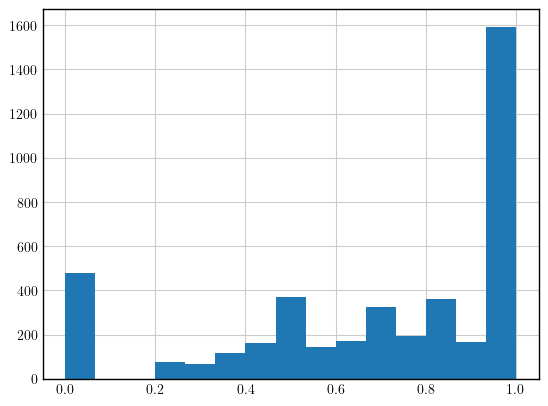

In [20]:
results.f1_scores.hist(bins=15)

<Axes: >

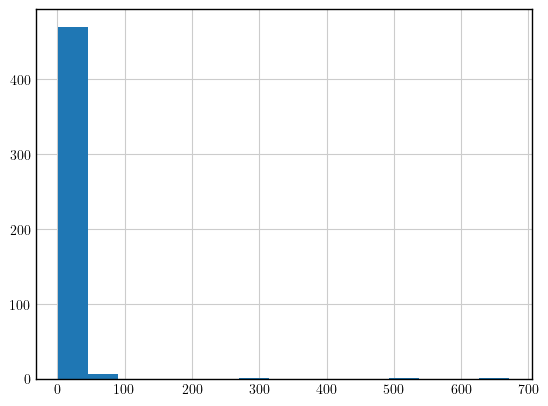

In [21]:
worst_finishes.med_scores.hist(bins=15)

In [22]:
# sparse-bar formation of the same histogram data
ax = (
  worst_finishes
  .med_scores
  .sort_values()
  .map(lambda x: (x // 10) * 10)
  .map(lambda x: "[" + str(int(x)) + ", " + str(int(x+10)) + ")")
  .value_counts()
  # .plot.bar()
)
# ax.set_yscale('log')
print(ax.to_latex())
print(ax.to_markdown())

\begin{tabular}{lr}
\toprule
{} &  med\_scores \\
\midrule
[0, 10)    &         160 \\
[10, 20)   &         155 \\
[20, 30)   &         114 \\
[30, 40)   &          34 \\
[40, 50)   &          10 \\
[50, 60)   &           2 \\
[60, 70)   &           1 \\
[270, 280) &           1 \\
[500, 510) &           1 \\
[670, 680) &           1 \\
\bottomrule
\end{tabular}

|            |   med_scores |
|:-----------|-------------:|
| [0, 10)    |          160 |
| [10, 20)   |          155 |
| [20, 30)   |          114 |
| [30, 40)   |           34 |
| [40, 50)   |           10 |
| [50, 60)   |            2 |
| [60, 70)   |            1 |
| [270, 280) |            1 |
| [500, 510) |            1 |
| [670, 680) |            1 |


<ipython-input-22-5e1a2c78a10c>:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(ax.to_latex())


<Axes: >

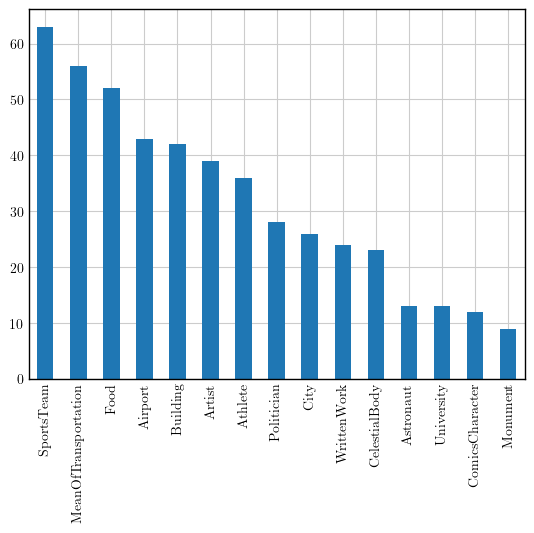

In [23]:
worst_finishes.category.value_counts().plot.bar()

In [24]:
train_corpus = corpus[corpus.subset == 'train']
train_corpus.category.value_counts().plot.bar()

NameError: name 'corpus' is not defined

<Axes: >

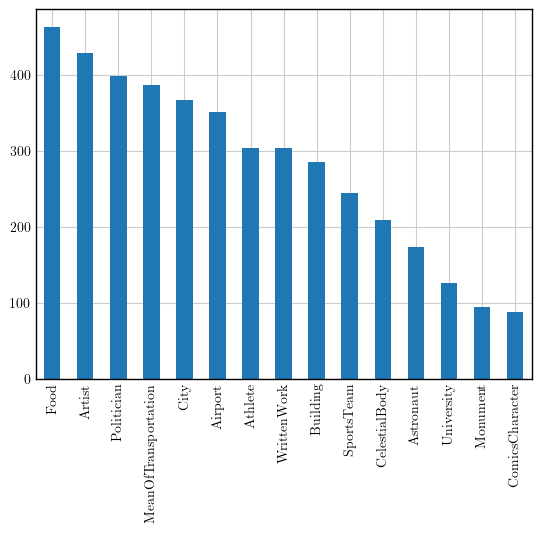

In [25]:
train_corpus = test_predictions
train_corpus.category.value_counts().plot.bar()

<Axes: >

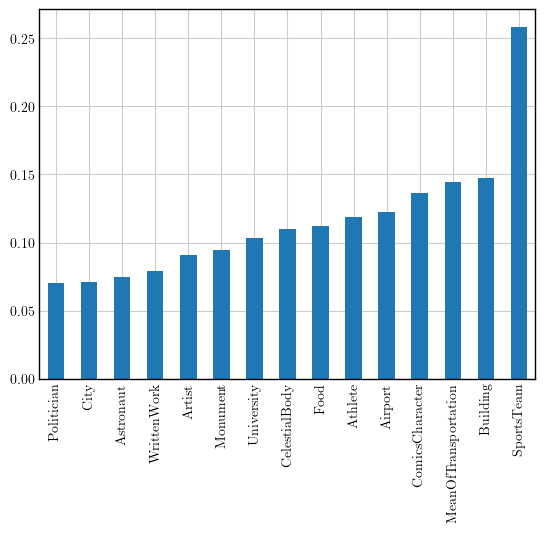

In [26]:
# normalized performance by category
npc = worst_finishes.category.value_counts() / train_corpus.category.value_counts()
npc.sort_values().plot.bar()

 the network performs poorly on buildings, sports teams, and monuments when
 normalized for class prevalence. Poor performance on monument may be explained
 by its under-representation in the training set. This does not hold for sports
 teams and monuments, which have good representation in the training set but do
 not have good performance. This points to qualitative features particular to
 entries in those categories.

In [27]:
worst_finishes.sort_values(by=['med_scores'])

,record_idx,seed_number,subset,category,split_index,sd,nl,input_ids,attention_mask,labels,pred_ids,decoded,f1_scores,med_scores,nth_finish
39121,14680,0,test,City,185,"Auburn, Washington|area total|77.41 (square ki...",Auburn (Washington) has a total area of 77.4 s...,"[28384, 41, 518, 3198, 6029, 61, 65, 3, 9, 792...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[28384, 6, 2386, 9175, 498, 792, 9175, 4013, 5...","[0, 28384, 6, 2386, 9175, 498, 792, 9175, 4013...","Auburn, Washington|area total|77.4 (square kil...",0.0,1.000000,3745
38954,14607,1,test,Athlete,112,Italy national under-16 football team|coach|Da...,Daniele Zoratto is coach of the Italy national...,"[4173, 15, 6226, 1795, 235, 19, 3763, 13, 8, 5...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[5308, 1157, 365, 10892, 3370, 372, 9175, 509,...","[0, 5308, 1157, 365, 10892, 3370, 372, 9175, 5...",Italy national under-16 football team|coach|Da...,0.0,1.000000,3745
39012,14635,0,test,Building,140,Julia Morgan|significant building|Los Angeles ...,Julia Morgan has designed many significant bui...,"[18618, 11147, 65, 876, 186, 1516, 3950, 6, 37...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[18618, 11147, 9175, 26251, 740, 9175, 434, 32...","[0, 18618, 11147, 9175, 26251, 740, 9175, 434,...",Julia Morgan|significant building|Los Angeles ...,0.0,1.000000,3745
38784,14542,2,test,Artist,47,Aleksandra Kovac|birth place|Yugoslavia,Yugoslavia is the birth place of Aleksandra Ko...,"[6214, 839, 17457, 23, 9, 19, 8, 3879, 286, 13...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[901, 16789, 152, 3515, 1793, 8938, 9175, 2066...","[0, 901, 16789, 152, 3515, 1793, 8938, 9175, 2...",Aleksandra Kovac|birth place|Yougoslavia,0.0,1.000000,3745
38783,14542,1,test,Artist,47,Aleksandra Kovac|birth place|Yugoslavia,The birth place of Aleksandra Kovac is Yugosla...,"[37, 3879, 286, 13, 901, 16789, 152, 3515, 179...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[901, 16789, 152, 3515, 1793, 8938, 9175, 2066...","[0, 901, 16789, 152, 3515, 1793, 8938, 9175, 2...",Aleksandra Kovac|birth place|Yougoslavia,0.0,1.000000,3745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41817,15691,0,test,Food,1196,Beef kway teow|country|Singapore; Beef kway te...,Beef kway teow is a popular dish in Singapore ...,"[10024, 89, 3, 157, 1343, 3, 17, 15, 2381, 19,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[10024, 89, 3, 157, 1343, 3, 17, 15, 2381, 917...","[0, 10024, 89, 3, 157, 1343, 3, 17, 15, 2381, ...",Beef kway teow|region|Singapore and Indonesia;...,0.0,58.333333,3745
40403,15170,1,test,WrittenWork,675,Abhandlungen aus dem Mathematischen Seminar de...,Julius Springer founded Springer Science and B...,"[9983, 302, 4328, 49, 5710, 4328, 49, 2854, 11...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[891, 20873, 35, 403, 340, 9762, 15, 3357, 177...","[0, 891, 20873, 35, 403, 340, 9762, 15, 3357, ...",Abhandlungen aus dem Mathematischen Seminar de...,0.0,60.000000,3745
42463,15930,2,test,City,1435,"Anderson, Indiana|is part of|Fall Creek Townsh...","Located in the United States, in Madison Count...","[3, 8691, 16, 8, 907, 1323, 6, 16, 16168, 1334...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[11825, 6, 11494, 9175, 159, 294, 13, 9175, 37...","[0, 11825, 20381, 6, 11825, 20381, 6, 11825, 2...","Anderson Township, Anderson Township, Anderson...",0.0,273.000000,3745
40339,15145,2,test,SportsTeam,650,AFC Ajax (amateurs)|ground|Sportpark De Toekom...,Jong Ajax are the tenants of the De Toekomst S...,"[8178, 122, 71, 1191, 226, 33, 8, 16801, 13, 8...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[71, 5390, 71, 1191, 226, 41, 265, 12552, 61, ...","[0, 71, 5, 371, 5, 254, 5, 71, 5, 371, 5, 254,...",A.F.C. A.F.C. A.F.C. A.F.C. A.F.C. A.F.C. A.F....,0.0,508.000000,3745
